In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from nflows import flows, transforms, distributions
from tqdm import tqdm

from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism
from src.dimension_reduction.principal_geodesic_analysis.vector.l2_tangent_space_pca import l2TangentSpacePCAVectorSolver
from src.manifolds.euclidean.vector.pullback.standard import StandardPullbackVectorEuclidean
from src.manifolds.isometrized_euclidean.vector import l2IsometrizedVectorEuclidean
from src.transforms.parity.tanh import TanhParityTransform
from src.transforms.householder_linear import HouseholderLinearTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(31)

plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Learning Geometry ###

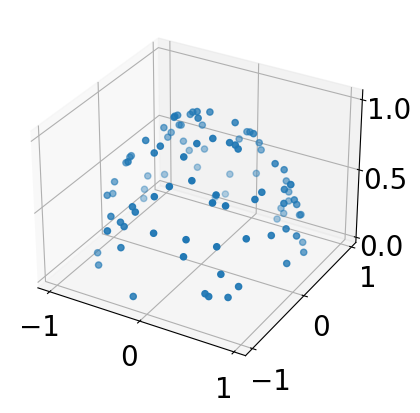

In [2]:
# Construct dataset
def uniform_sphere_sampling(dim, num_samples):
    """
    Generate uniform samples on a unit sphere in dim dimensions using PyTorch.
    """
    samples = torch.randn(num_samples, dim)
    samples /= torch.norm(samples, dim=1, keepdim=True)
    samples[:,2] *= torch.sign(samples[:,2])
    return samples

num_samples = 100

data_clean = uniform_sphere_sampling(3, num_samples)
mean = data_clean.mean(0)
data_train = data_clean - mean[None]

train_loader = DataLoader(data_train, batch_size=16, shuffle=False)

# plot data
ax = plt.axes(projection='3d')
ax.scatter(data_clean[:,0], data_clean[:,1], data_clean[:,2])
plt.show()

In [3]:
# Define the normalizing flow model
def create_flow_model(dim, n_flows, n_hoho, order):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for i in range(n_flows):
        transforms_list.append(transforms.normalization.ActNorm(features=dim))
        for k in range(n_hoho):
            transforms_list.append(HouseholderLinearTransform(dim))
        transforms_list.append(TanhParityTransform(dim, order, parity=i%2))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return flows.Flow(transform=flow_transforms, distribution=base_dist)

In [4]:
# Initialize the model
dim = 3
n_flows = 3
n_hoho = 3
order = 2
model = create_flow_model(dim, n_flows, n_hoho, order).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.02)

In [5]:
# Training loop
def train(model, train_loader, optimizer, n_epochs):
    for epoch in range(n_epochs):
        for x in train_loader:
            optimizer.zero_grad()
            
            # Compute loss
            loss = -model.log_prob(x.to(device)).mean()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

In [6]:
# Train the model
n_epochs = 500
train(model, train_loader, optimizer, n_epochs)

Epoch 1/500, Loss: 2.0018
Epoch 2/500, Loss: 1.9649
Epoch 3/500, Loss: 1.9302
Epoch 4/500, Loss: 1.8992
Epoch 5/500, Loss: 1.8719
Epoch 6/500, Loss: 1.8483
Epoch 7/500, Loss: 1.8277
Epoch 8/500, Loss: 1.8098
Epoch 9/500, Loss: 1.7941
Epoch 10/500, Loss: 1.7801
Epoch 11/500, Loss: 1.7676
Epoch 12/500, Loss: 1.7563
Epoch 13/500, Loss: 1.7461
Epoch 14/500, Loss: 1.7367
Epoch 15/500, Loss: 1.7280
Epoch 16/500, Loss: 1.7200
Epoch 17/500, Loss: 1.7126
Epoch 18/500, Loss: 1.7057
Epoch 19/500, Loss: 1.6992
Epoch 20/500, Loss: 1.6931
Epoch 21/500, Loss: 1.6873
Epoch 22/500, Loss: 1.6818
Epoch 23/500, Loss: 1.6766
Epoch 24/500, Loss: 1.6716
Epoch 25/500, Loss: 1.6668
Epoch 26/500, Loss: 1.6623
Epoch 27/500, Loss: 1.6580
Epoch 28/500, Loss: 1.6540
Epoch 29/500, Loss: 1.6502
Epoch 30/500, Loss: 1.6466
Epoch 31/500, Loss: 1.6434
Epoch 32/500, Loss: 1.6403
Epoch 33/500, Loss: 1.6375
Epoch 34/500, Loss: 1.6349
Epoch 35/500, Loss: 1.6325
Epoch 36/500, Loss: 1.6303
Epoch 37/500, Loss: 1.6283
Epoch 38/5

In [7]:
# Generate samples
@torch.no_grad()
def generate_samples(model, n_samples):
    samples = model.sample(n_samples).cpu()
    return samples

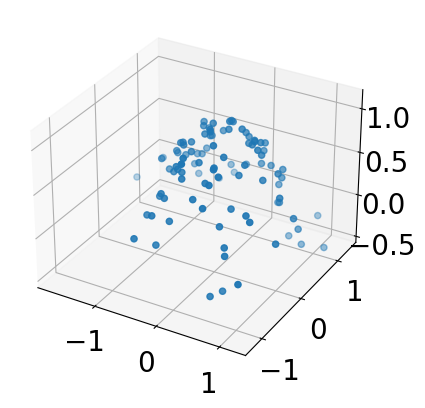

In [8]:
# Visualize generated samples
samples = generate_samples(model, 100) + mean

ax = plt.axes(projection='3d')
ax.scatter(samples[:,0], samples[:,1], samples[:,2])
plt.show()

In [9]:
# Construct diffeomorphism
phi = NFlowVectorDiffeomorphism(3, model)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


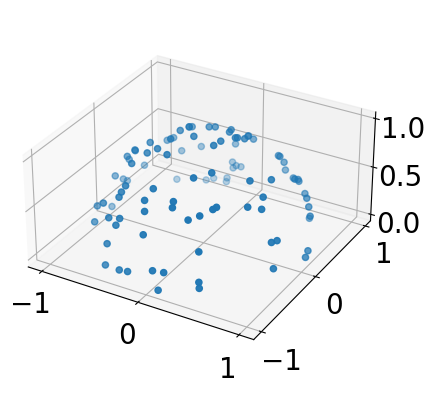

In [10]:
# special points
x0 = (torch.tensor([0.,1.,0.]) - mean).to(device)
x1 = (torch.tensor([0.,-1.,0.]) - mean).to(device)

# validation data
data_val = uniform_sphere_sampling(3, num_samples) - mean

ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/data.eps")
plt.show()

### Naive Riemannian data analysis ###

In [11]:
# Construct pullback manifold
manifold = StandardPullbackVectorEuclidean(phi)

In [12]:
# test interpolation
t = torch.linspace(0.,1.,20).to(device)

geodesic = manifold.geodesic(x0,x1,t).detach().cpu()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


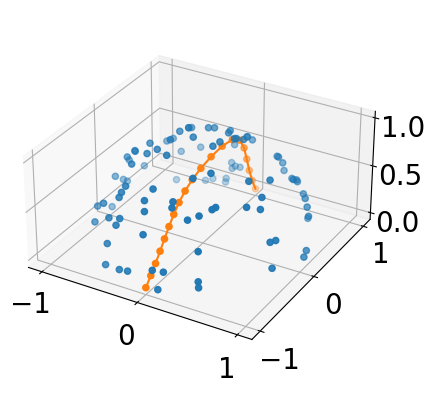

In [13]:
# plot geodesics
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.plot((geodesic + mean)[:,0].numpy(), (geodesic + mean)[:,1].numpy(), (geodesic + mean)[:,2].numpy(), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax.scatter((geodesic + mean)[:,0], (geodesic + mean)[:,1], (geodesic + mean)[:,2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/geodesic.eps")
plt.show()

In [14]:
# compute barycentre
bary = manifold.barycentre(data_train.to(device)).detach().cpu()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


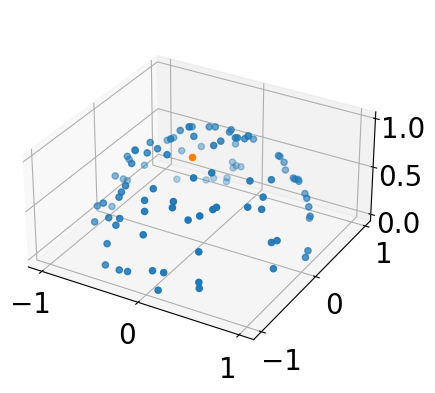

In [15]:
# plot barycentres
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.scatter((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/barycentre.eps")
plt.show()

In [16]:
# construct curvature corrected l2-pga solver
l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data_val.to(device), manifold, bary.to(device))

In [17]:
# compute low rank approximations
Xi_bary, exp_bary_Xi, _ = l2_pga_solver_bary.solve(2) # compute rank 2 approximation

Computing rank 2 approximation on tangent space
Computing rank 2 approximation on euclidean space
Computing rank 2 errors


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


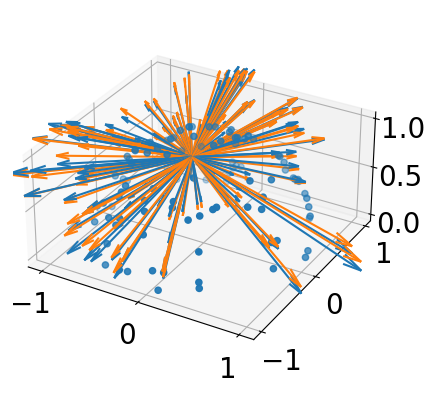

In [18]:
# plot tangent space approximations
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.scatter((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    ax.quiver((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], 
             l2_pga_solver_bary.log_x_data[i, 0].cpu(), l2_pga_solver_bary.log_x_data[i, 1].cpu(), l2_pga_solver_bary.log_x_data[i, 2].cpu(), 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], 
             arrow_length_ratio=0.1)
    ax.quiver((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], 
             Xi_bary[i, 0].cpu(), Xi_bary[i, 1].cpu(), Xi_bary[i, 2].cpu(), 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
             arrow_length_ratio=0.1)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/l2-pga-tvectors.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


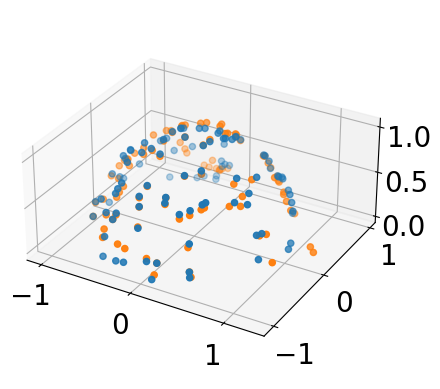

In [19]:
# plot data approximations
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.scatter((exp_bary_Xi.cpu()+mean)[:,0], (exp_bary_Xi.cpu()+mean)[:,1], (exp_bary_Xi.cpu()+mean)[:,2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/l2-pga.eps")
plt.show()

### Isometrized Riemannian data analysis ###

In [20]:
# Construct isometrized pullback manifold
iso_manifold = l2IsometrizedVectorEuclidean(manifold, num_intervals=100)

In [21]:
# compute geodesic
t = torch.linspace(0.,1.,20).to(device)

iso_geodesic = iso_manifold.geodesic(x0,x1,t).detach().cpu()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


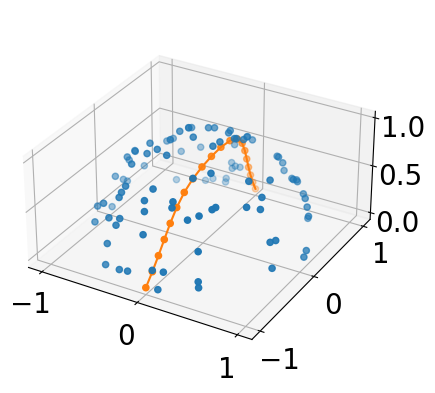

In [22]:
# plot geodesics
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.plot((iso_geodesic + mean)[:,0].numpy(), (iso_geodesic + mean)[:,1].numpy(), (iso_geodesic + mean)[:,2].numpy(), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax.scatter((iso_geodesic + mean)[:,0], (iso_geodesic + mean)[:,1], (iso_geodesic + mean)[:,2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/iso-geodesic.eps")
plt.show()

In [23]:
# construct l2-pga solver
iso_l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data_val.to(device), iso_manifold, bary.to(device))

In [24]:
# compute low rank approximations
iso_Xi_bary, iso_exp_bary_Xi, _ = iso_l2_pga_solver_bary.solve(2) # compute rank 2 approximation

Computing rank 2 approximation on tangent space
Computing rank 2 approximation on euclidean space
Computing rank 2 errors


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


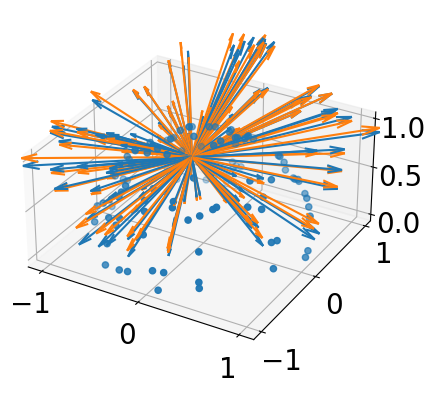

In [25]:
# plot tangent space approximations
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.scatter((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
for i in range(iso_l2_pga_solver_bary.log_x_data.shape[0]):
    ax.quiver((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], 
             iso_l2_pga_solver_bary.log_x_data[i, 0].cpu(), iso_l2_pga_solver_bary.log_x_data[i, 1].cpu(), iso_l2_pga_solver_bary.log_x_data[i, 2].cpu(), 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], 
             arrow_length_ratio=0.1)
    ax.quiver((bary+mean)[0], (bary+mean)[1], (bary+mean)[2], 
             iso_Xi_bary[i, 0].cpu(), iso_Xi_bary[i, 1].cpu(), iso_Xi_bary[i, 2].cpu(), 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
             arrow_length_ratio=0.1)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/iso-l2-pga-tvectors.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


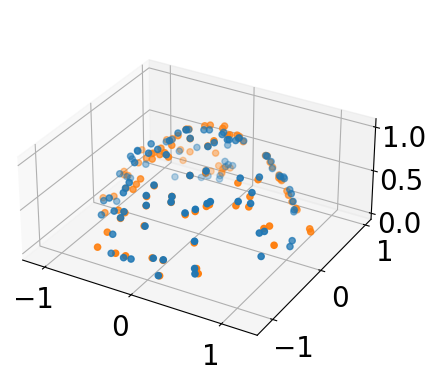

In [26]:
# plot data approximations
ax = plt.axes(projection='3d')
ax.scatter((data_val+mean)[:,0] , (data_val+mean)[:,1], (data_val+mean)[:,2])
ax.scatter((iso_exp_bary_Xi.cpu()+mean)[:,0], (iso_exp_bary_Xi.cpu()+mean)[:,1], (iso_exp_bary_Xi.cpu()+mean)[:,2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/iso-l2-pga.eps")
plt.show()

### Comparing naive and isometrized ###

In [27]:
# Compute geodesic relative rmse from the barycentre
squared_geo_errors = torch.zeros(data_val.shape[0])
dists = ((data_val - bary)**2).sum(1)
for i, x_i in enumerate(data_val):
    geodesic_i = manifold.geodesic(bary.to(device), x_i.to(device), t).detach().cpu()
    iso_geodesic_i = iso_manifold.geodesic(bary.to(device), x_i.to(device), t).detach().cpu()
    squared_geo_errors[i] = ((geodesic_i - iso_geodesic_i)**2).mean(0).sum()

geo_rel_rmse = (squared_geo_errors.mean() / dists.mean()).sqrt()
print(geo_rel_rmse)

tensor(0.0409)


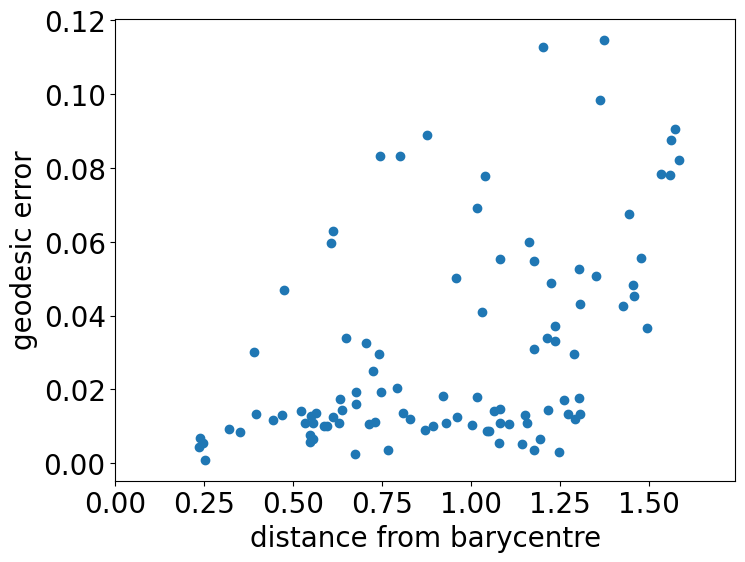

In [28]:
# Make scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dists.sqrt(), squared_geo_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.xlabel('distance from barycentre')
plt.ylabel('geodesic error')
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/geo-error.eps")
plt.show()

In [29]:
# Compute low rank relative rmse from the barycentre
squared_low_rank_errors = ((data_val - exp_bary_Xi.cpu())**2).sum(1)
low_rank_rel_rmse = (squared_low_rank_errors.mean() / dists.mean()).sqrt()

squared_low_rank_iso_errors = ((data_val - iso_exp_bary_Xi.cpu())**2).sum(1)
iso_low_rank_rel_rmse = (squared_low_rank_iso_errors.mean() / dists.mean()).sqrt()

print(low_rank_rel_rmse)
print(iso_low_rank_rel_rmse)

tensor(0.1682)
tensor(0.1153)


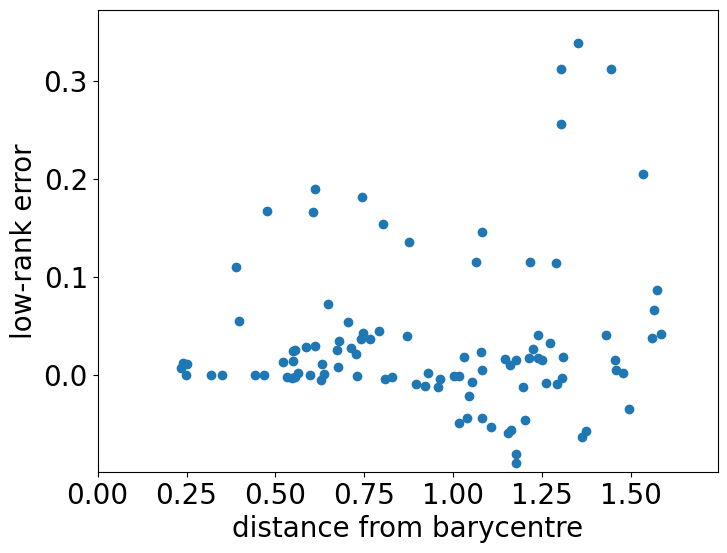

In [30]:
# Make scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dists.sqrt(), squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.ylim([(squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt()).min()*1.1, (squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt()).max()*1.1])
plt.xlabel('distance from barycentre')
plt.ylabel('low-rank error')
plt.savefig("results/hemi_sphere/additive-tanh-isotropic-nflow-pullback/low-rank-error.eps")
plt.show()